### Libraries

In [1]:
from gurobipy import *
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

In [2]:
num_cl_nodes,num_ncl_nodes,num_permanent_lanes,num_transient_lanes,num_clusters,num_carriers = 2,2,[2,2],[1,1],2,2

nodes = np.concatenate((make_blobs(n_samples=num_cl_nodes, centers=num_clusters, cluster_std=30, random_state=10,center_box=(0, 1000))[0], make_blobs(n_samples=num_ncl_nodes, centers=num_ncl_nodes, cluster_std=0.60, random_state=0,center_box=(0, 1000))[0]))

num_lanes = sum(num_permanent_lanes) + sum(num_transient_lanes)
total_lanes = [num_permanent_lanes[i] + num_transient_lanes[i] for i in range(num_carriers)]

np.random.seed(0)
permanent_lanes = np.random.randint(0,len(nodes),[sum(num_permanent_lanes),2])
for j in range(sum(num_permanent_lanes)):
    if permanent_lanes[j][0] == permanent_lanes[j][1]:
        if j == 0:
            permanent_lanes[j] = [0,1]
        else:
            permanent_lanes[j] = permanent_lanes[0]

np.random.seed(1)
transient_lanes = np.random.randint(0,len(nodes),[sum(num_transient_lanes),2])
for j in range(sum(num_transient_lanes)):
    if transient_lanes[j][0] == transient_lanes[j][1]:
        if j == 0:
            transient_lanes[j] = [0,1]
        else:
            transient_lanes[j] = transient_lanes[0]

distance_matrix = distance.cdist(nodes, nodes, 'euclidean')

carrier_idx_pr = np.ones((1,1))
for k in range(num_carriers):
    temp = np.ones((num_permanent_lanes[k],1))*k
    carrier_idx_pr = np.vstack((carrier_idx_pr, temp))
carrier_idx_pr = np.delete(carrier_idx_pr, (0), axis=0)

carrier_idx_tr = np.ones((1,1))
for k in range(num_carriers):
    temp = np.ones((num_transient_lanes[k],1))*k
    carrier_idx_tr = np.vstack((carrier_idx_tr, temp))
carrier_idx_tr = np.delete(carrier_idx_tr, (0), axis=0)

carrier_idx = np.vstack((carrier_idx_pr, carrier_idx_tr))

permanent_lanes = np.hstack((permanent_lanes, carrier_idx_pr))
transient_lanes = np.hstack((transient_lanes, carrier_idx_tr))

lanes = np.concatenate((permanent_lanes,transient_lanes))

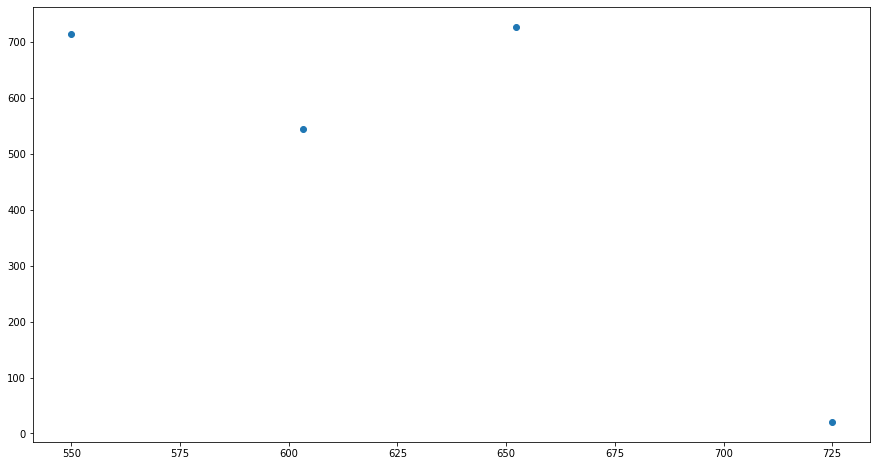

In [3]:
# points = np.concatenate((permanent_lanes, transient_lanes))
points = nodes
xx,yy = points[:,0], points[:,1]
plt.figure(figsize=(15,8))
plt.scatter(xx, yy)
plt.show()

### Create Model

In [4]:
mod_MCLCP = Model(name = 'MCLCP')


--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2021-12-28
Using license file C:\Users\Student\gurobi.lic


### Indices & Parameters

$Lanes \subset Arcs$

$ N: $ Number of nodes

$k: $ Number of carries

$c_{ij}: $ cost of carrying freight from node i to j

In [5]:
N = list(range(num_cl_nodes + num_ncl_nodes))
K = list(range(num_carriers))

I = permanent_lanes.astype(int)
II = [x for x in I.tolist()]
I_ijk = np.zeros((len(N),len(N))).astype(int)
for ele in I:
    I_ijk[ele[0]][ele[1]] = I_ijk[ele[0]][ele[1]] + 1
I_k = np.zeros((len(N),len(N),len(K))).astype(int)
for ele in I:
    I_k[ele[0]][ele[1]][ele[2]] = I_k[ele[0]][ele[1]][ele[2]] + 1

L = transient_lanes.astype(int)
    
r = np.zeros((len(N),len(N))).astype(int)
for ele in L:
    r[ele[0]][ele[1]] = r[ele[0]][ele[1]] + 1
    
    
A = np.array([[i, j] for i in range((num_cl_nodes + num_ncl_nodes)) for j in range((num_cl_nodes + num_ncl_nodes)) if i != j])
c = distance_matrix.astype(int)
theta = np.array([0.5,0.5])

In [6]:
sum(sum(I_ijk))
I
I_ijk
I_k

array([[[0, 0],
        [0, 0],
        [0, 0],
        [1, 2]],

       [[1, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0],
        [0, 0]]])

### Decision Variables

In [7]:
x = mod_MCLCP.addVars(len(N),len(N),len(K), lb = 0, ub = 2000, name = 'x', vtype = GRB.INTEGER)
z = mod_MCLCP.addVars(len(N),len(N),len(K), lb = 0, ub = 2000, name = 'z', vtype = GRB.INTEGER)

### Objective Function

In [8]:
# mod_MCLCP.setObjective(quicksum(quicksum(c[ele[0]][ele[1]]*x[ele[0],ele[1],k] for ele in L) for k in K) + (quicksum(theta[k]*quicksum(c[ele[0]][ele[1]]*z[ele[0],ele[1],k] for ele in A) for k in K)), GRB.MINIMIZE)

### Constraints

In [15]:
# # ###########  2 ########### OK
mod_MCLCP.addConstrs(quicksum(x[i,j,k] for j in N) - quicksum(x[j,i,k] for j in N) + quicksum(z[i,j,k] for j in N) - quicksum(z[j,i,k] for j in N) == 0 for i in N for k in K)

# # ###########  3 ########### OK
mod_MCLCP.addConstrs(quicksum(x[L[ele][0],L[ele][1],k] for k in K) - I_ijk[L[ele][0]][L[ele][1]] - r[L[ele][0]][L[ele][1]] == 0 for ele in range(len(L)))

# # ###########  4 ########### OK
mod_MCLCP.addConstrs(x[I[ele][0],I[ele][1],k] - I_k[I[ele][0]][I[ele][1]][k] >= 0 for k in K for ele in range(len(I)))


{(0, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 3): <gurobi.Constr *Awaiting Model Update*>,
 (1, 0): <gurobi.Constr *Awaiting Model Update*>,
 (1, 1): <gurobi.Constr *Awaiting Model Update*>,
 (1, 2): <gurobi.Constr *Awaiting Model Update*>,
 (1, 3): <gurobi.Constr *Awaiting Model Update*>}

### Optimize

In [16]:
# mod_MCLCP.optimize()


# if (mod_MCLCP.Status == GRB.INFEASIBLE):
#     print('No feasible solution')

#     mod_MCLCP.computeIIS()
#     for q in mod_MCLCP.getConstrs():
#         if q.IISConstr:
#             print('%s' % q.constrName)
# elif (mod_MCLCP.status == GRB.UNBOUNDED):
#     print('Unbounded')

# elif (mod_MCLCP.status == GRB.INF_OR_UNBD):
#     print('Infeasible or Unbounded')

# elif (mod_MCLCP.Status == GRB.TIME_LIMIT) and (((mod_MCLCP.modelSense == GRB.MINIMIZE) and (mod_MCLCP.objVal > 1e30)) or ((mod_MCLCP.modelSense == GRB.MAXIMIZE) and (mod_MCLCP.objVal < -1e30))):
#     print('No feasible solution')

# else:
#     print('Objective Function Value:', mod_MCLCP.objVal)

#     if (mod_MCLCP.Status == GRB.OPTIMAL):
#         print('\optimal objective function value')
#     elif (mod_MCLCP.Status == GRB.TIME_LIMIT):
#         print('\tTime limit reached.\n')
#         print('\tBest Bound:', mod_MCLCP.ObjBound)

#     print('\nSolution:')
#     for var in mod_MCLCP.getVars():
#         if (abs(var.X) > mod_MCLCP.Params.INT_FEAS_TOL):
#             print('\t', var.VarName, "=", var.X)


In [17]:
mod_MCLCP.optimize()
Vars = []
X={key:x[key].x for key in x.keys()}
Z={key:z[key].X for key in z.keys()}
for v in mod_MCLCP.getVars():
    if v.x>0:
        Vars.append(['%s %g' % (v.varName, v.x)])
obj = mod_MCLCP.objVal

print("Exact solution is: " + str(obj))
print()
print()
print()
print()
print('x= ',X)
print()
print()
print()
print()
print('z= ',Z)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 36 rows, 64 columns and 216 nonzeros
Model fingerprint: 0xbc69aebb
Variable types: 0 continuous, 64 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+01, 1e+03]
  Bounds range     [2e+03, 2e+03]
  RHS range        [1e+00, 2e+00]

Loaded MIP start from previous solve with objective 2860

Presolve removed 28 rows and 27 columns
Presolve time: 0.09s
Presolved: 8 rows, 37 columns, 76 nonzeros
Variable types: 0 continuous, 37 integer (0 binary)

Explored 0 nodes (0 simplex iterations) in 0.11 seconds
Thread count was 8 (of 8 available processors)

Solution count 1: 2860 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.860000000000e+03, best bound 2.860000000000e+03, gap 0.0000%
Exact solution is: 2860.0




x=  {(0, 0, 0): 0.0, (0, 0, 1): 0.0, (0, 1, 0): 0.0, (0, 1, 1): 0.0, (0

In [13]:
print(I)
print(L)

[[0 3 0]
 [1 0 0]
 [0 3 1]
 [0 3 1]]
[[1 3 0]
 [1 3 1]]


In [18]:
c

array([[  0, 710, 188, 103],
       [710,   0, 538, 715],
       [188, 538,   0, 178],
       [103, 715, 178,   0]])